# Titanic - Machine Learning from Disaster

The goal is to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data. This is a a binary classification problem where we have the following variables in the dataset:
- **survival**: Survival status  
  - `0 = No`, `1 = Yes`

- **pclass**: Ticket class  
  - `1 = 1st`, `2 = 2nd`, `3 = 3rd`

- **sex**: Sex of the passenger

- **age**: Age in years

- **sibsp**: Number of siblings or spouses aboard the Titanic

- **parch**: Number of parents or children aboard the Titanic

- **ticket**: Ticket number

- **fare**: Passenger fare paid

- **cabin**: Cabin number

- **embarked**: Port of Embarkation  
  - `C = Cherbourg`, `Q = Queenstown`, `S = Southampton`

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
# Import data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Combine the datasets to analyze missing
train_data['train'] = 1
test_data['train'] = 0
combined_data = pd.concat([train_data, test_data], ignore_index=True)

combined_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


In [4]:
# Distribution of response variable
print(train_data['Survived'].value_counts(normalize=True) * 100)

Survived
0    61.616162
1    38.383838
Name: proportion, dtype: float64


## Analyze missing data

In [6]:
# Percentage of missing values per variable
print("\nPercentage of missing values:")
print(combined_data.drop('Survived', axis=1).isnull().mean() * 100)


Percentage of missing values:
PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.091673
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.076394
Cabin          77.463713
Embarked        0.152788
train           0.000000
dtype: float64


There are missing data for *Age*, *Cabin*, *Embarked* and *Fare*. People without *Cabin* information can go to a category of people without cabin. There are few missings for *Embarked* and *Fare*. Below, we will analyze the relationship between age and sex, age and ticket class, and age and title name.

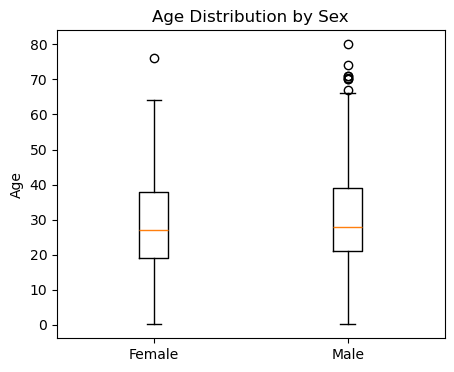

In [8]:
male_ages = combined_data[combined_data['Sex'] == 'male']['Age'].dropna()
female_ages = combined_data[combined_data['Sex'] == 'female']['Age'].dropna()

plt.figure(figsize=(5, 4))
plt.boxplot([female_ages, male_ages], tick_labels=['Female', 'Male'])
plt.title('Age Distribution by Sex')
plt.ylabel('Age')
plt.show()

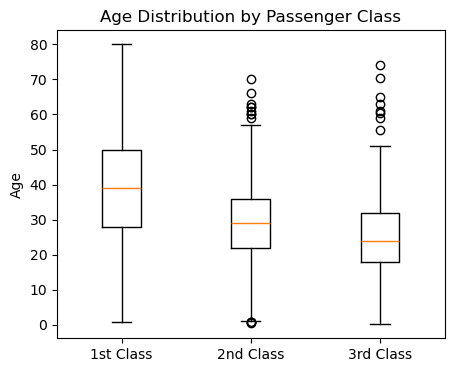

In [9]:
class1_ages = combined_data[combined_data['Pclass'] == 1]['Age'].dropna()
class2_ages = combined_data[combined_data['Pclass'] == 2]['Age'].dropna()
class3_ages = combined_data[combined_data['Pclass'] == 3]['Age'].dropna()

plt.figure(figsize=(5, 4))
plt.boxplot([class1_ages, class2_ages, class3_ages], tick_labels=['1st Class', '2nd Class', '3rd Class'])
plt.title('Age Distribution by Passenger Class')
plt.ylabel('Age')
plt.show()

In [10]:
# Creating title based on name
combined_data['Title'] = combined_data['Name'].str.extract(r',\s*([^\.]*)\s*\.', expand=False)
combined_data['Title'].value_counts()

Title
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

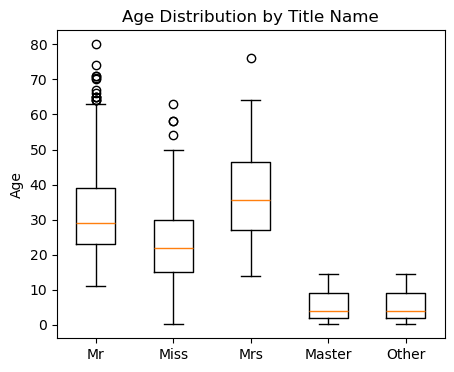

In [11]:
# Group rare titles into 'Other'
top_titles = ['Mr', 'Miss', 'Mrs', 'Master']
combined_data['Title'] = combined_data['Title'].apply(lambda x: x if x in top_titles else 'Other')
    
Mr_ages = combined_data[combined_data['Title'] == "Mr"]['Age'].dropna()
Miss_ages = combined_data[combined_data['Title'] == "Miss"]['Age'].dropna()
Mrs_ages = combined_data[combined_data['Title'] == "Mrs"]['Age'].dropna()
Master_ages = combined_data[combined_data['Title'] == "Master"]['Age'].dropna()
Other_ages = combined_data[combined_data['Title'] == "Master"]['Age'].dropna()

plt.figure(figsize=(5, 4))
plt.boxplot([Mr_ages, Miss_ages, Mrs_ages, Master_ages, Other_ages], tick_labels=['Mr', 'Miss', 'Mrs', 'Master', 'Other'])
plt.title('Age Distribution by Title Name')
plt.ylabel('Age')
plt.show()

It seems that there is a relationshipt between age and class, and between age and title name.

## Data pre-processing

The pre-processing of the data will include:

1. **Imputation of missing values**:
   - `Embarked`: We will impute this variable with the mode.
   - `Fare`: We will impute this variable with the median.
   - `Age`: We will impute the median grouped by `Sex`, `Pclass` and `Title`.

2. **Creation of derived features**:
   - `HasCabin`: `1` if the passenger had a cabin, else `0`.
   - `FamilySize`: Number of members of his family on board (including himself).

3. **Exclusion of not needed features that could bring noise to the model**:
   - `PassengerId`: Just a row identifier, has no predictive value.
   - `Name`: High cardinality, complex text — we already extracted `Title`.
   - `Ticket`: Unique values.
   - `Cabin`: Inconsistent and sparse, probably also unique.

In [14]:
comb_df = combined_data.copy()

# Create derived features
comb_df['HasCabin'] = comb_df['Cabin'].notnull().astype('int')
comb_df['FamilySize'] = comb_df['SibSp'] + comb_df['Parch'] + 1

# Impute Embarked with the mode
comb_df['Embarked'] = comb_df['Embarked'].fillna(comb_df['Embarked'].mode()[0])

# Impute Fare with the median
comb_df['Fare'] = comb_df['Fare'].fillna(comb_df['Fare'].median())

# Impute Age with median grouped by Sex, Pclass and Title
comb_df['Age'] = comb_df.groupby(['Sex', 'Pclass', 'Title'])['Age'].transform(lambda x: x.fillna(x.median()))
# If some combinations of variables do not exist, impute only with Sex and Pclass
comb_df['Age'] = comb_df.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
    
# Drop irrelevant features
comb_df = comb_df.drop(['PassengerId','Name', 'Ticket', 'Cabin'], axis=1)

In [15]:
# Variables to use as predictors
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "Title", "HasCabin", "FamilySize"]

# One-hot-enconding
X_df = pd.get_dummies(comb_df[features + ["train"]])

# Train and test datasets
X_train = X_df[X_df['train']==1].drop('train', axis=1)
X_test = X_df[X_df['train']==0].drop('train', axis=1)

y_train = train_data["Survived"]

## Selecting the model

To select the model, we will use cross-validation based on the accuracy and hyperparameter tuning for the following models:
- Random forest
- Logistic regression
- Gradient boosting
- Neural networks

### Random forest

In [18]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': list(range(70, 120, 10)),  # Number of trees
    'max_depth': list(range(5, 40, 5))         # Maximum depth of each tree
}

# Initialize the base model
rf = RandomForestClassifier(random_state=12345)

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Run the grid search on the training data
grid_search.fit(X_train, y_train)

# Display the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)

Best parameters: {'max_depth': 5, 'n_estimators': 100}
Best cross-validated accuracy: 0.832741196409516


### Logistic regression

In [20]:
# Initialize the logistic regression model
logreg_model = LogisticRegression(random_state=54321, solver='liblinear')
scores = cross_val_score(logreg_model, X_train, y_train, cv=5, scoring='accuracy')
final_score = scores.mean()
print("Cross-validated accuracy:", final_score)

Cross-validated accuracy: 0.8316301550436256


### Gradient boosting

In [22]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Initialize the base model
gb_model = GradientBoostingClassifier(random_state=123)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit the grid search on your training data
grid_search.fit(X_train, y_train)

# Show the best combination of parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

Best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}
Best accuracy: 0.8350197727700708


### Neural networks

In [24]:
# Define the parameter grid for tuning
param_grid = {
    'hidden_layer_sizes': [(20,), (50,), (100,), (50, 50)], # Number of neurons/layers
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],  # L2 regularization
    'learning_rate_init': [0.001, 0.01]
}

# Initialize the base MLP model
mlp_model = MLPClassifier(max_iter=1000, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=mlp_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Run grid search on the training data
grid_search.fit(X_train, y_train)

# Display the best parameters and cross-validated score
print("Best parameters (MLP):", grid_search.best_params_)
print("Best accuracy (MLP):", grid_search.best_score_)

Best parameters (MLP): {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001}
Best accuracy (MLP): 0.827154604230745


## Selected model

Based on the accuracy, the selected model is Gradient boosting with the following hyper-parameters:

In [26]:
# Model with the best parameters
best_gb_model = GradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=4,
    n_estimators=200,
    random_state=1234
)

# Fit the model on the training data
best_gb_model.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.05
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,4
,min_impurity_decrease,0.0
,init,None


Accuracy on the full dataset: 0.9360


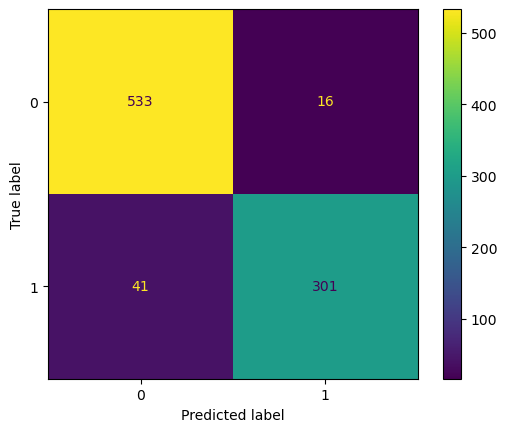

In [27]:
# Compute accuracy
accuracy = best_gb_model.score(X_train, y_train)
print(f"Accuracy on the full dataset: {accuracy:.4f}")

# Compute and display confusion matrix
cm = confusion_matrix(y_train, best_gb_model.predict(X_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Below we present the most important features in the model. These are: If the person is a Mr, the passenger fare, the age, the ticket class and the family size.

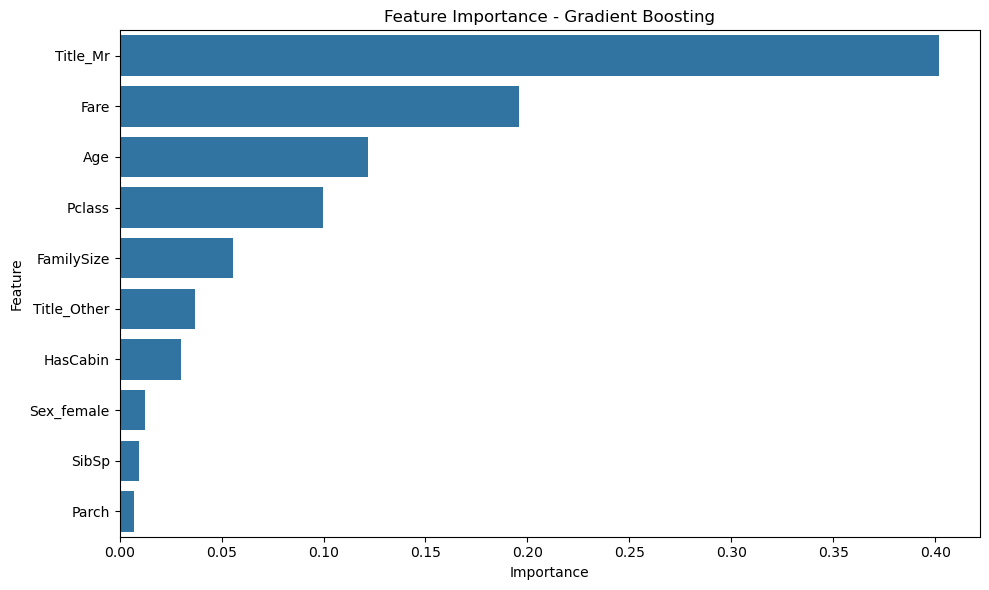

In [29]:
# Get feature importances
importances = best_gb_model.feature_importances_

# Create a DataFrame with feature names and their importance
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

# Display as a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance - Gradient Boosting')
plt.tight_layout()
plt.show()

## Prediction for test dataset

In [31]:
proba_survive = best_gb_model.predict(X_test)
kaggle_predictions = pd.DataFrame({
        "PassengerId": test_data["PassengerId"],
        "Survived": (proba_survive >= 0.5).astype(int)
    })

kaggle_predictions

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [37]:
path="Submission.csv"
kaggle_predictions.to_csv(path, index=False)